In [2]:
import Yukawa_SINDy as ys
import Yukawa3body as y3
import numpy as np
import pysindy as ps

In [21]:
# load in data
sim_list = y3.load_data('data/basic_noisy/analysis_trajectories')
# load in SINDy models for 0 noise case
nonoise_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00000/model_objs')
# remove models with threshold > 1 from list
nonoise_models = [model for model in nonoise_models if model.optimizer.threshold <= 1]

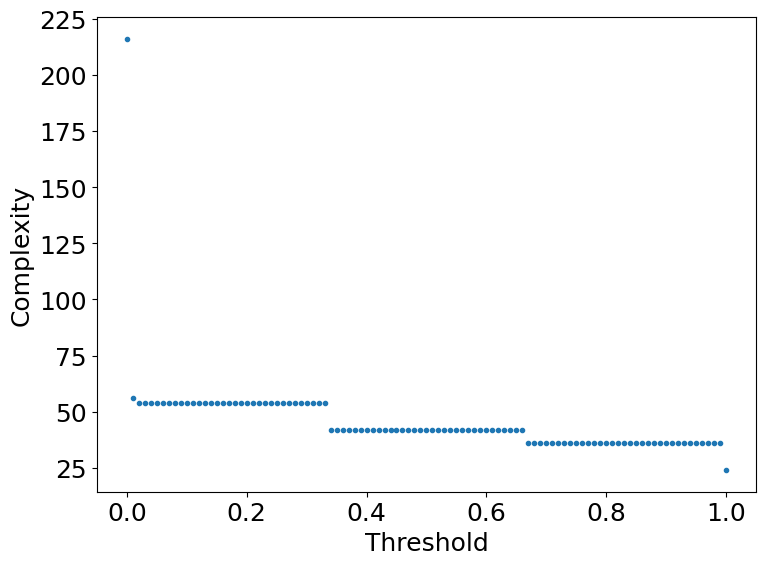

In [22]:
ys.plot_complexity_objs(nonoise_models)

In [23]:
y3.print_SINDy_nice(nonoise_models[66])

----------------------------------------------------------------------------------------------------
STLSQ threshold: 0.66
complexity: 42
----------------------------------------------------------------------------------------------------
(x0-x1)'      = 1.000 vx0-vx1

(vx0-vx1)'    = 2.180 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.993 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)
              + -1.073 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.997 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)
              + -1.058 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -0.997 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)

(y0-y1)'      = 1.000 vy0-vy1

(vy0-vy1)'    = 2.173 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 1.993 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2

In [ ]:
for sim in sim_list:
    # sim.delete_noise()
    sim.add_gaussian_noise(noise_level=1e-1)

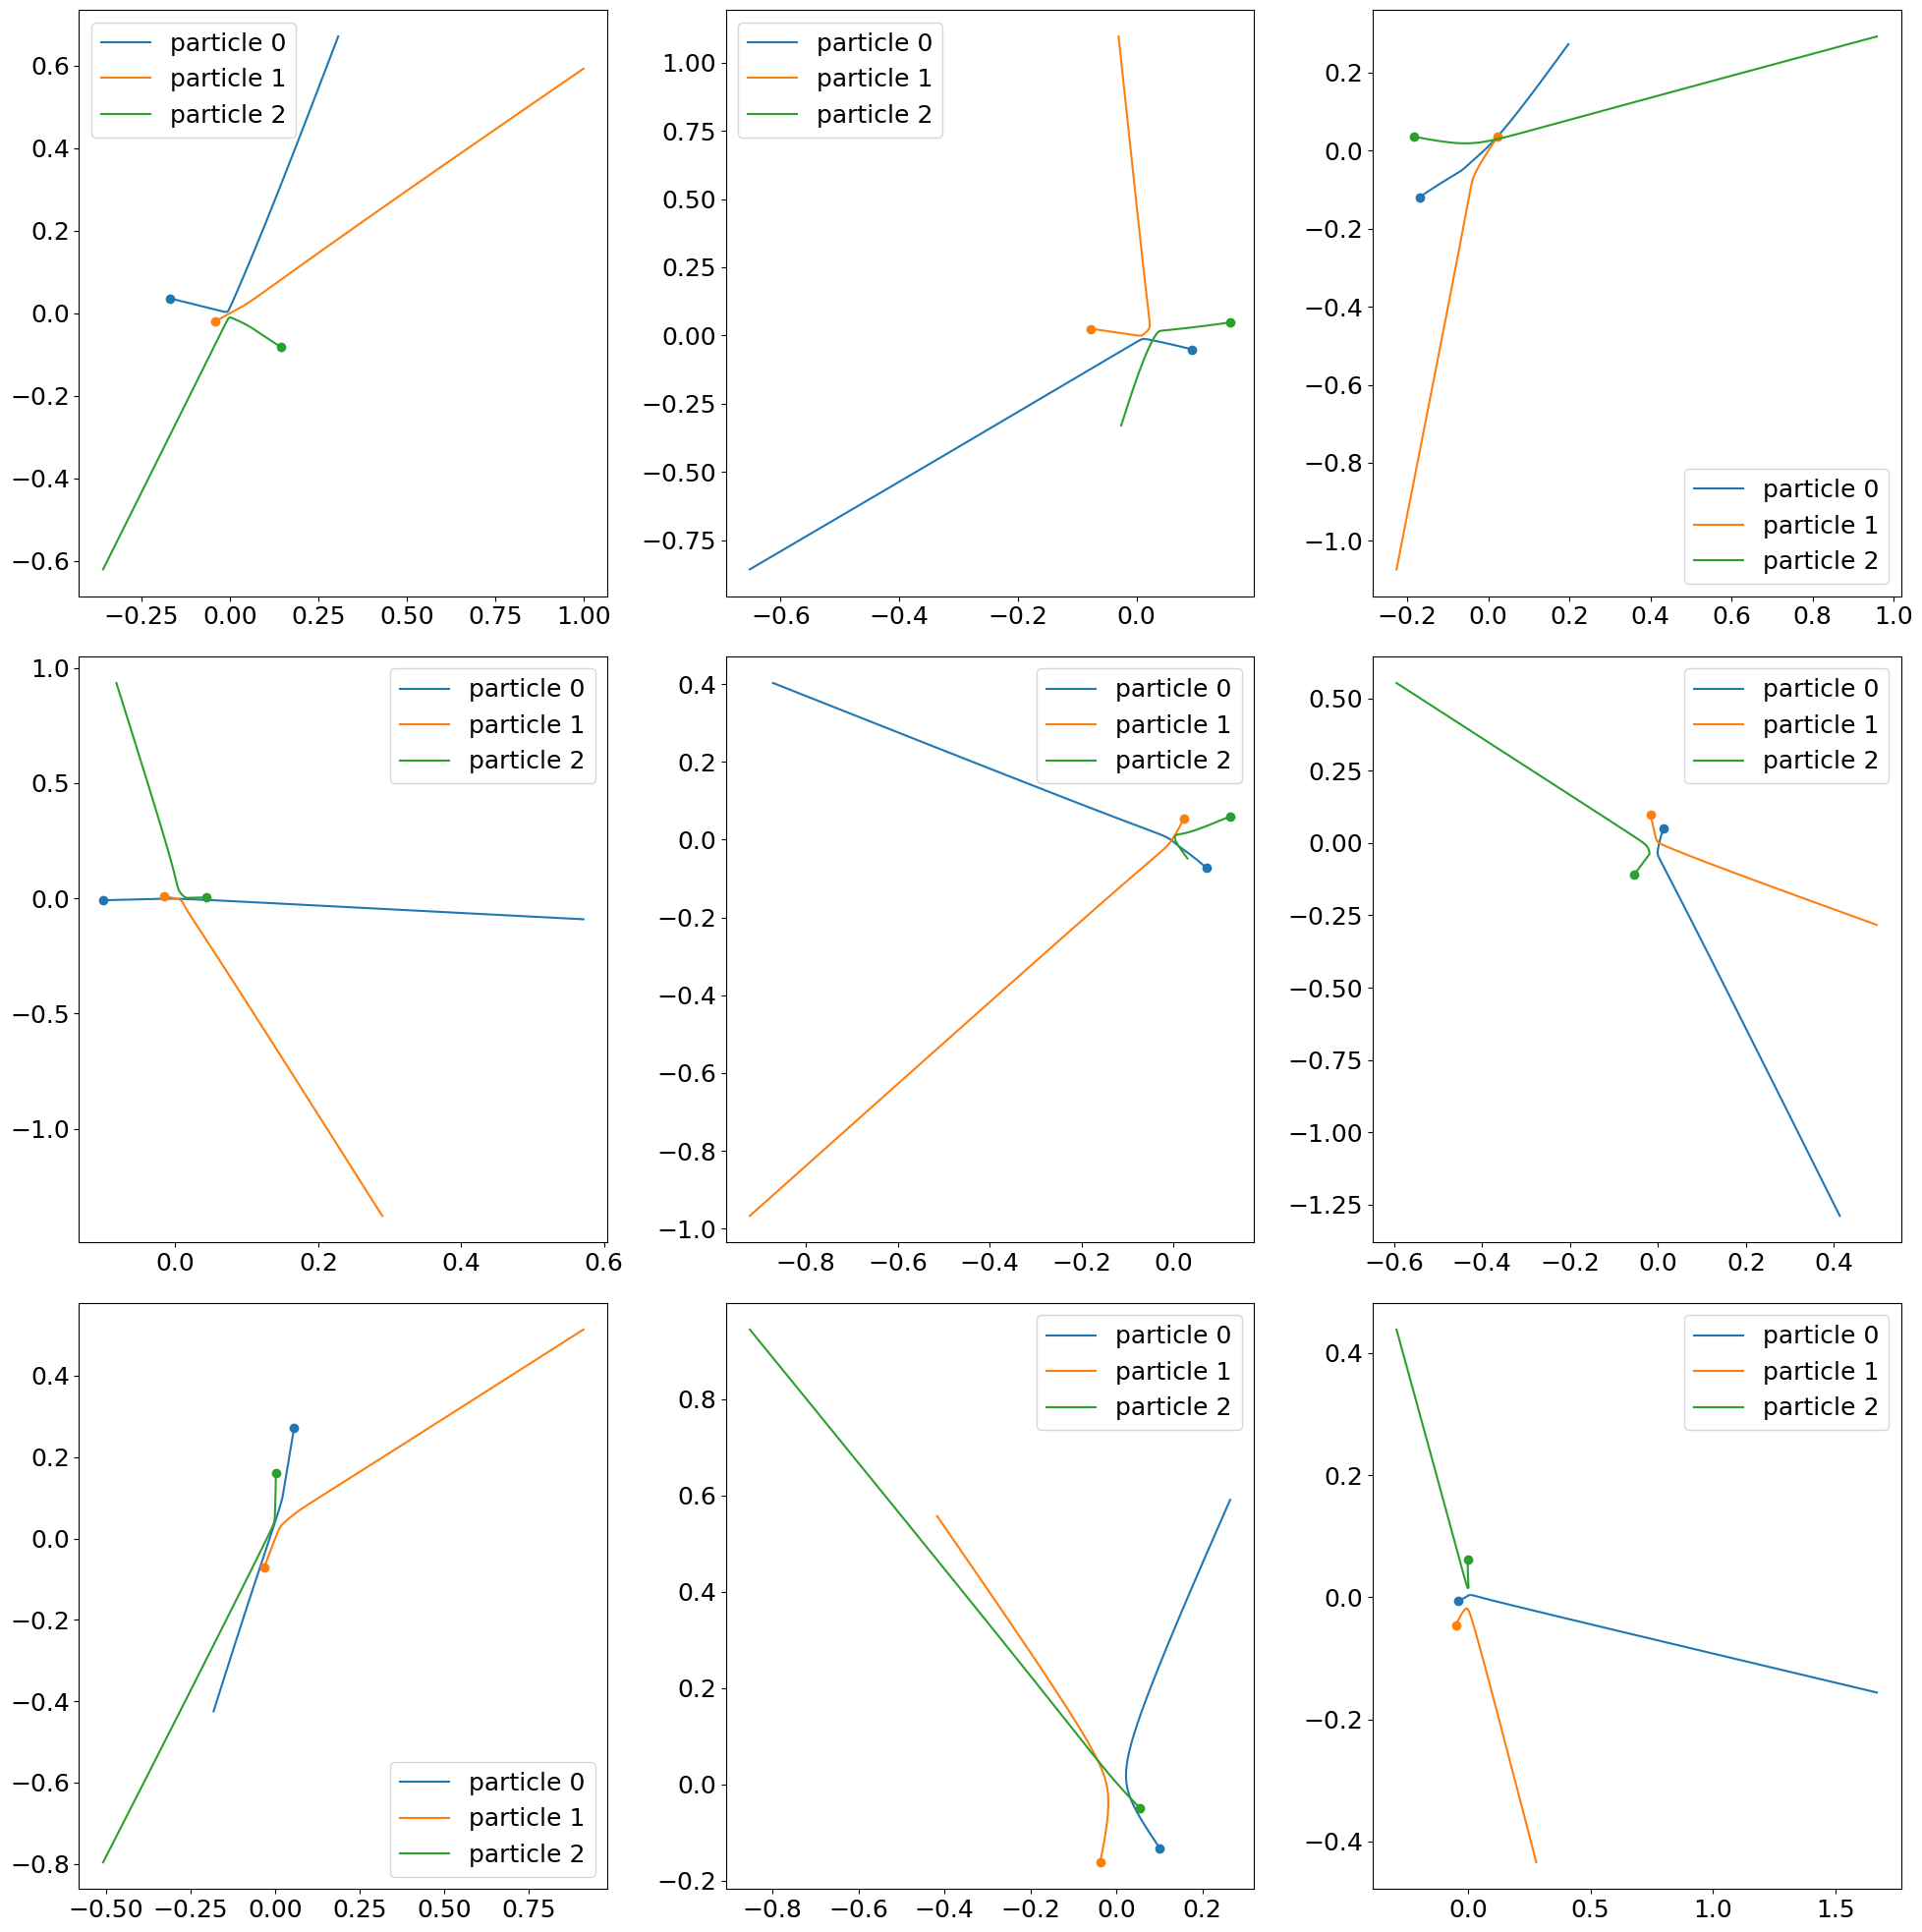

In [26]:

y3.plot_multiple(sim_list)